## 1. Model Training
We train a data prediction model using darts framework and NBEATS Deep Learning model.

In [1]:
%pip install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import digitalhub as dh

proj = dh.get_or_create_project('parcheggi-demo')
di = proj.get_dataitem(entity_name='dataset')
df = di.as_df()
df.head()

,parcheggio,data,posti_liberi,posti_occupati,posti_totali,lat,lon
0,VIII Agosto,2024-06-07T01:59:00+00:00,484.0,141.0,625,44.500297,11.345368
1,Riva Reno,2024-06-07T02:09:00+00:00,369.0,101.0,470,44.501153,11.336062
2,Riva Reno,2024-06-07T02:19:00+00:00,369.0,101.0,470,44.501153,11.336062
3,VIII Agosto,2024-06-07T02:29:00+00:00,487.0,138.0,625,44.500297,11.345368
4,Riva Reno,2024-06-07T02:29:00+00:00,369.0,101.0,470,44.501153,11.336062


### 1.1. Prepare data

Clean data: convert date to datetime and calculate occupied ratio, remove redundant columns.

In [3]:
import datetime
import pandas as pd

window = 60

df_clean = df.copy()
df_clean.data = pd.to_datetime(df_clean.data, utc=True)
df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
df_clean['date_time_slice'] = df_clean.data.dt.round('30min').dt.tz_convert(None)
df_clean = df_clean[df_clean.date_time_slice >= (datetime.datetime.today() - pd.DateOffset(window))]
df_clean = df_clean[df_clean.date_time_slice <= (datetime.datetime.today() - pd.DateOffset(1))]
df_clean.posti_occupati = df_clean.apply(lambda x: max(0, min(x['posti_totali'], x['posti_occupati'])), axis=1)
df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
df_clean = df_clean.drop(columns=['lat', 'lon', 'data', 'posti_totali', 'posti_liberi', 'posti_occupati'])
df_clean.head()

,parcheggio,occupied,date_time_slice
0,VIII Agosto,0.225600,2024-06-07 02:00:00
1,Riva Reno,0.214894,2024-06-07 02:00:00
2,Riva Reno,0.214894,2024-06-07 02:30:00
3,VIII Agosto,0.220800,2024-06-07 02:30:00
4,Riva Reno,0.214894,2024-06-07 02:30:00


### 1.2. Create multiple time series

/tmp/ipykernel_46331/4040877996.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parc_df['hour'] = parc_df.date_time_slice.dt.hour
/tmp/ipykernel_46331/4040877996.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
/tmp/ipykernel_46331/4040877996.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

<AxesSubplot: xlabel='date_time_slice'>

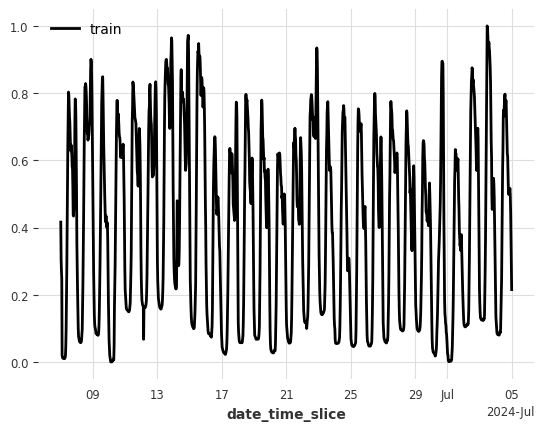

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

split_ratio = 0.8

def fill_missing(parc_df):
    missing = []  # List to store timestamps for which values could not be filled
    temp = pd.Series(parc_df.index.date).value_counts()  # Count the occurrences of each date
    temp = temp[temp < 48]  # Filter dates with less than 48 occurrences
    temp.sort_index(inplace=True)  # Sort the dates in ascending order
    for t in temp.index:  # Iterate through the filtered dates
        for h in range(24):  # Iterate through 24 hours
            for half_hour in [0, 30]:  # Iterate through 0 and 30 minutes
                ts = datetime.datetime(t.year, t.month, t.day, h, half_hour)  # Create a timestamp
                if ts not in parc_df.index:  # If the timestamp is missing in the DataFrame
                    if ts - datetime.timedelta(days=7) in parc_df.index:  # Check if the previous week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts - datetime.timedelta(days=7)].copy()  # Copy values from the previous week
                    elif ts + datetime.timedelta(days=7) in parc_df.index:  # Check if the next week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts + datetime.timedelta(days=7)].copy()  # Copy values from the next week
                    else:
                        missing.append(ts)  # If values cannot be filled, add the timestamp to the missing list
    return missing 
parcheggi = df_clean['parcheggio'].unique()

train_sets, val_sets = [], []

for parcheggio in parcheggi:
    parc_df = df_clean[df_clean['parcheggio'] == parcheggio]
    parc_df['hour'] = parc_df.date_time_slice.dt.hour
    parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
    parc_df = parc_df.drop(columns=['parcheggio'])
    parc_df = parc_df.groupby('date_time_slice').agg({'occupied': 'mean', 'hour': 'first', 'dow': 'first'})
    fill_missing(parc_df)
    ts = TimeSeries.from_dataframe(parc_df,  value_cols='occupied', freq='30min')
    ts_scaled = Scaler().fit_transform(ts)

    split = int(len(ts_scaled) * (1 - split_ratio))

    train, val = ts_scaled[:-split], ts_scaled[-split:]
    train_sets.append(train)
    val_sets.append(val)
    
train_sets[0].plot(label='train')

In [5]:
from darts.models import NBEATSModel

multimodel =  NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=10,
        random_state=0
    )

multimodel.fit(train_sets)

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | stacks        | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=10, random_state=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<AxesSubplot: xlabel='date_time_slice'>

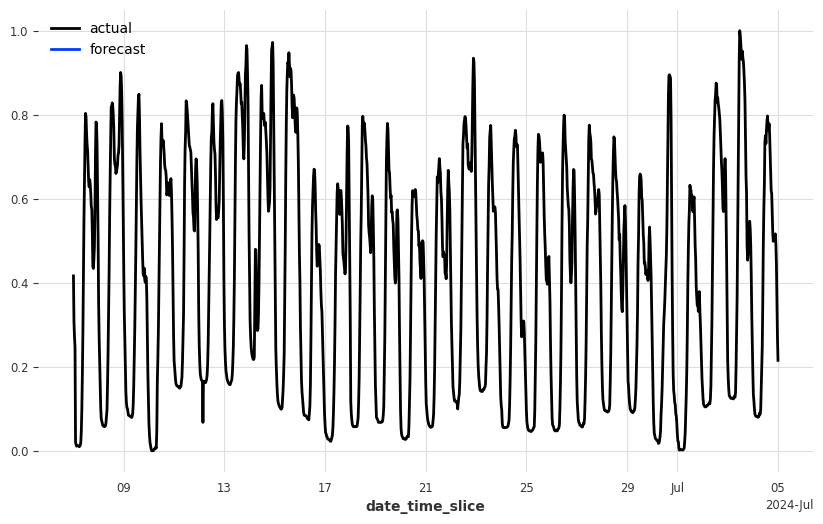

In [6]:
import matplotlib.pyplot as plt

pred = multimodel.predict(n=24, series=train_sets[0][:-24])

plt.figure(figsize=(10, 6))
train_sets[0].plot(label="actual")
pred.plot(label="forecast")

In [7]:
from darts.metrics import mape, smape, mae

metrics = {
    "mape": mape(train_sets[0], pred),
    "smape": smape(train_sets[0], pred),
    "mae": mae(train_sets[0], pred)
}
metrics

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'mape': nan, 'smape': nan, 'mae': nan}

## 2. ML Ops
With the help of the platform, we will create the training function, train a parking occupation prediction model, and deploy it to the cluster as an inference API.

### 2.1. Initalization
Create the working context: data management project for the parking data processing. Project is a placeholder for the code, data, and management of the parking data operations. 

In [9]:
import digitalhub as dh

ml_proj = dh.get_or_create_project("parcheggi-demo")

### 2.2. ML training function
We convert the ML operations into a function - single executable operation that can be executed in the platform.

In [10]:
%%writefile "src/train_multimodel.py"

import pandas as pd
from digitalhub_runtime_python import handler
from darts import TimeSeries

from darts.models import NBEATSModel
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from zipfile import ZipFile

import logging
logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

import datetime

import pandas as pd
import datetime

from pickle import dumps

def fill_missing(parc_df):
    missing = []  # List to store timestamps for which values could not be filled
    temp = pd.Series(parc_df.index.date).value_counts()  # Count the occurrences of each date
    temp = temp[temp < 48]  # Filter dates with less than 48 occurrences
    temp.sort_index(inplace=True)  # Sort the dates in ascending order
    for t in temp.index:  # Iterate through the filtered dates
        for h in range(24):  # Iterate through 24 hours
            for half_hour in [0, 30]:  # Iterate through 0 and 30 minutes
                ts = datetime.datetime(t.year, t.month, t.day, h, half_hour)  # Create a timestamp
                if ts not in parc_df.index:  # If the timestamp is missing in the DataFrame
                    if ts - datetime.timedelta(days=7) in parc_df.index:  # Check if the previous week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts - datetime.timedelta(days=7)].copy()  # Copy values from the previous week
                    elif ts + datetime.timedelta(days=7) in parc_df.index:  # Check if the next week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts + datetime.timedelta(days=7)].copy()  # Copy values from the next week
                    else:
                        missing.append(ts)  # If values cannot be filled, add the timestamp to the missing list
    return missing  # Return the list of timestamps for which values could not be filled


@handler()
def train_model(project, parkings_di,n_epochs: int = 1, window: int = 60, 
                input_chunk_length: int = 24, output_chunk_length: int = 12, 
                split_ratio: float = 0.8):

    # Load the input data
    df_source = parkings_di.as_df()
    # Clean the data
    df_clean = df_source.copy()
    df_clean.data = pd.to_datetime(df_clean.data, utc=True)
    df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
    df_clean['date_time_slice'] = df_clean.data.dt.round('30min').dt.tz_convert(None)
    df_clean = df_clean[df_clean.date_time_slice >= (datetime.datetime.today() - pd.DateOffset(window))]
    df_clean = df_clean[df_clean.date_time_slice <= (datetime.datetime.today() - pd.DateOffset(1))]
    df_clean.posti_occupati = df_clean.apply(lambda x: max(0, min(x['posti_totali'], x['posti_occupati'])), axis=1)
    df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
    df_clean = df_clean.drop(columns=['lat', 'lon', 'data', 'posti_totali', 'posti_liberi', 'posti_occupati'])
    parcheggi = df_clean['parcheggio'].unique()

    train_sets, val_sets = [], []

    # Process data for each parking lot
    for parcheggio in parcheggi:
        parc_df = df_clean[df_clean['parcheggio'] == parcheggio]
        parc_df['hour'] = parc_df.date_time_slice.dt.hour
        parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
        parc_df = parc_df.drop(columns=['parcheggio'])
        parc_df = parc_df.groupby('date_time_slice').agg({'occupied': 'mean', 'hour': 'first', 'dow': 'first'})
        fill_missing(parc_df)
        ts = TimeSeries.from_dataframe(parc_df,  value_cols='occupied', freq='30min')
        ts_scaled = Scaler().fit_transform(ts)
        
        split = int(len(ts_scaled) * (1 - split_ratio))

        # Split data into training and validation sets
        train, val = ts_scaled[:-split], ts_scaled[-split:]
        train_sets.append(train)
        val_sets.append(val)

    # Train a multi-model using the NBEATS algorithm
    multimodel =  NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        random_state=0
    )

    # Fit the model to the training sets
    multimodel.fit(train_sets)
    pred = multimodel.predict(n=output_chunk_length*2, series=train_sets[0][:-output_chunk_length*2])

    multimodel.save("parcheggi_predictor_model.pt")
    with ZipFile("parcheggi_predictor_model.pt.zip", "w") as z:
        z.write("parcheggi_predictor_model.pt")
        z.write("parcheggi_predictor_model.pt.ckpt")
    project.log_model(name="modello_parcheggi", kind="model", source_path="parcheggi_predictor_model.pt.zip")


Writing src/train_multimodel.py


In [13]:
func = ml_proj.new_function(name="training_model",
                         kind="python",
                         python_version="PYTHON3_9",
                         source={"source": "src/train_multimodel.py", "handler": "train_model"})

In [14]:
func.run(action="build", instructions=["pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu","pip3 install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2"])

{'project': 'parcheggi-demo', 'id': '6d451a09-0d9e-44de-b623-e929ba88d8cb', 'kind': 'python+run', 'key': 'store://parcheggi-demo/runs/python+run/6d451a09-0d9e-44de-b623-e929ba88d8cb', 'metadata': {'project': 'parcheggi-demo', 'name': '6d451a09-0d9e-44de-b623-e929ba88d8cb', 'created': '2024-07-12T15:35:47.951Z', 'updated': '2024-07-12T15:35:47.959Z', 'created_by': 'tenant1userid', 'updated_by': 'tenant1userid'}, 'spec': {'task': 'python+build://parcheggi-demo/training_model:c2930674-8037-42d2-8c16-af362b16ee70', 'local_execution': False, 'source': {'source': 'src/train_multimodel.py', 'handler': 'train_model', 'base64': 'CmltcG9ydCBwYW5kYXMgYXMgcGQKZnJvbSBkaWdpdGFsaHViX3J1bnRpbWVfcHl0aG9uIGltcG9ydCBoYW5kbGVyCmZyb20gZGFydHMgaW1wb3J0IFRpbWVTZXJpZXMKCmZyb20gZGFydHMubW9kZWxzIGltcG9ydCBOQkVBVFNNb2RlbApmcm9tIGRhcnRzLm1ldHJpY3MgaW1wb3J0IG1hcGUsIHNtYXBlLCBtYWUKZnJvbSBkYXJ0cy5kYXRhcHJvY2Vzc2luZy50cmFuc2Zvcm1lcnMgaW1wb3J0IFNjYWxlcgpmcm9tIHppcGZpbGUgaW1wb3J0IFppcEZpbGUKCmltcG9ydCBsb2dnaW5nCmxvZ2dp

### 2.3. Train model
Execute train model function. As a result, the function produces a ML model that is uploaded to the platform storage, versioned, and enriched with metadata (e.g., metrics).

In [17]:
data_item_download = di.key
func.run(action="job", inputs={"parkings_di":data_item_download})

{'project': 'parcheggi-demo', 'id': '229e069e-d98d-4a74-a383-2c5293479068', 'kind': 'python+run', 'key': 'store://parcheggi-demo/runs/python+run/229e069e-d98d-4a74-a383-2c5293479068', 'metadata': {'project': 'parcheggi-demo', 'name': '229e069e-d98d-4a74-a383-2c5293479068', 'created': '2024-07-12T15:42:28.94Z', 'updated': '2024-07-12T15:42:28.95Z', 'created_by': 'tenant1userid', 'updated_by': 'tenant1userid'}, 'spec': {'task': 'python+job://parcheggi-demo/training_model:c2930674-8037-42d2-8c16-af362b16ee70', 'local_execution': False, 'source': {'source': 'src/train_multimodel.py', 'handler': 'train_model', 'base64': 'CmltcG9ydCBwYW5kYXMgYXMgcGQKZnJvbSBkaWdpdGFsaHViX3J1bnRpbWVfcHl0aG9uIGltcG9ydCBoYW5kbGVyCmZyb20gZGFydHMgaW1wb3J0IFRpbWVTZXJpZXMKCmZyb20gZGFydHMubW9kZWxzIGltcG9ydCBOQkVBVFNNb2RlbApmcm9tIGRhcnRzLm1ldHJpY3MgaW1wb3J0IG1hcGUsIHNtYXBlLCBtYWUKZnJvbSBkYXJ0cy5kYXRhcHJvY2Vzc2luZy50cmFuc2Zvcm1lcnMgaW1wb3J0IFNjYWxlcgpmcm9tIHppcGZpbGUgaW1wb3J0IFppcEZpbGUKCmltcG9ydCBsb2dnaW5nCmxvZ2dpbmcu

### 2.4. Deploy Model
Next, we deploy the model in the serving function. Given that the interaction does not correspond to a standard MLRun model server, we will deploy the function as a custom server. See the implementation of ``serve_multimodel.py`` for more details. 

For this, we add the model to the serving function in the initialization method.

In [18]:
%%writefile "serve_multimodel.py"

from darts.models import NBEATSModel
from zipfile import ZipFile

def init(context):
    # Qua ti setti l'id del modello che vuoi caricare
    model_id = "8be239dc-8798-48ff-bc3b-80d1d80cc2af"

    # prendi l'entity model sulla base dell'id
    model = context.project.get_model(entity_id=model_id)
    path = model.download()
    local_path_model = "extracted_model/"
    # Qua fai unzip immagino
    with ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(local_path_model)
    
    # codice che carica il modello
    input_chunk_length = 24
    output_chunk_length = 12
    name_model_local = local_path_model +"parcheggi_predictor_model.pt"
    mm = NBEATSModel(
            input_chunk_length,
            output_chunk_length
    ).load(name_model_local)

    # settare model nel context di nuclio (non su project che è il context nostro)
    context.setattr("model", mm)
    #setattr(context, "model", mm)

def serve(context, event):

    # Sostanzialmente invochiamo la funzione con una chiamata REST
    # Nel body della richiesta mandi l'inference input
    
    if isinstance(event.body, bytes):
        body = json.loads(event.body)
    context.logger.info(f"Received event: {body}")
    inference_input = body["inference_input"]
    
    return context.model.predict(n=output_chunk_length*2,
                                 series=inference_input)

Writing serve_multimodel.py


In [19]:
func = ml_proj.new_function(name="serve_model",
                            kind="python",
                            python_version="PYTHON3_9",
                            base_image = "python:3.9",
                            source={
                                 "source": "serve_multimodel.py",
                                 "handler": "serve",
                                 "init_function": "init"})

In [20]:
run_build_model_serve = func.run(action="build",instructions=["pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu","pip3 install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2"])

In [ ]:
run_serve_model = func.run(action="serve")